In [1]:
import numpy
import matplotlib.pyplot as plt
import scipy.optimize

In [2]:
def sys(s):
    return numpy.array([[4.05 * numpy.exp(-27*s) / (50*s + 1),
                         1.77 * numpy.exp(-28*s) / (60*s + 1),
                         5.88 * numpy.exp(-27*s) / (50*s + 1)],
                        [5.39 * numpy.exp(-18*s) / (50*s + 1),
                         5.72 * numpy.exp(-14*s) / (60*s + 1),
                         6.90 * numpy.exp(-15*s) / (40*s + 1)],
                        [4.38 * numpy.exp(-20*s) / (33*s + 1),
                         4.42 * numpy.exp(-22*s) / (44*s + 1),
                         7.20 * numpy.exp(-0*s) / (19*s + 1)]])

def compensator(s):
    return numpy.matrix([
[ (0.7758*s**4 + 0.2897*s**3 + 0.6933*s**2 + 0.2112*s + 0.8522)/(0.3698*s**4 + 0.7059*s**3 + 0.7068*s**2 + 0.1573*s + 0.849), (0.6347*s**4 + 0.92*s**3 + 0.9788*s**2 + 0.1182*s + 0.2724)/(0.4146*s**4 + 0.4356*s**3 + 0.7927*s**2 + 0.0507*s + 0.6826),     (0.246*s**4 + 0.1986*s**3 + 0.918*s**2 + 0.2371*s + 0.7241)/(1.1449*s**4 + 0.56*s**3 + 0.1516*s**2 + 0.0809*s + 0.5492)],
[(0.4154*s**4 + 0.4907*s**3 + 0.6919*s**2 + 0.7222*s + 0.6596)/(0.8712*s**4 + 0.3248*s**3 + 0.7562*s**2 + 0.1188*s + 0.7187), (0.143*s**4 + 0.9381*s**3 + 0.0363*s**2 + 0.5935*s + 0.3953)/(0.8651*s**4 + 0.1523*s**3 + 0.3149*s**2 + 0.2693*s + 0.429),    (0.2802*s**4 + 0.331*s**3 + 0.9575*s**2 + 0.2682*s + 0.1605)/(0.8115*s**4 + 0.804*s**3 + 0.8133*s**2 + 0.939*s + 0.4737)],
[ (0.7387*s**4 - 0.0239*s**3 + 0.262*s**2 + 0.3662*s + 0.8999)/(0.7673*s**4 + 0.0962*s**3 + 0.8871*s**2 + 0.3849*s + 1.0315),   (0.7456*s**4 + 0.3656*s**3 + 0.0758*s**2 + 0.5717*s + 0.69)/(0.2821*s**4 + 0.5967*s**3 + 0.0065*s**2 + 0.06*s + 0.5726), (1.0878*s**4 + 0.7457*s**3 + 0.4789*s**2 + 0.0271*s + 0.8954)/(0.5798*s**4 + 0.0496*s**3 + 0.1238*s**2 + 0.1125*s + 0.4841)]])

In [3]:
G = lambda s: sys(s) @ compensator(s)

In [4]:
ws = numpy.logspace(-6, 6, 1000)
jws = 1j*ws
diag_freq = numpy.array([numpy.diag(G(jw)) for jw in jws])

0


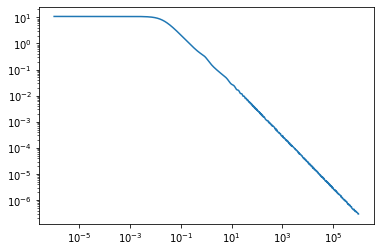

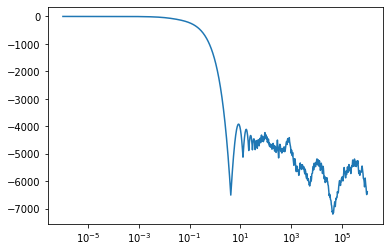

1


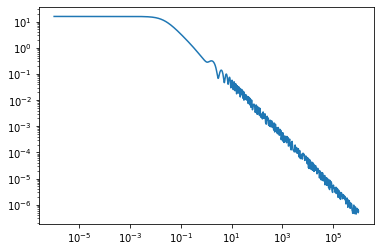

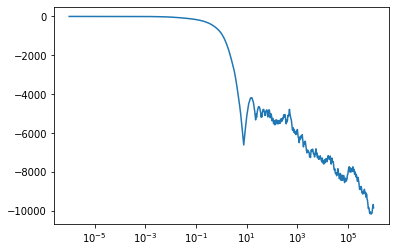

2


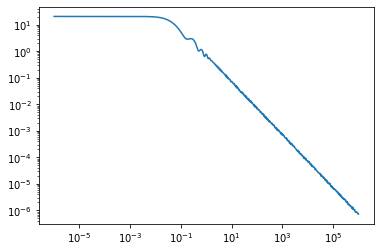

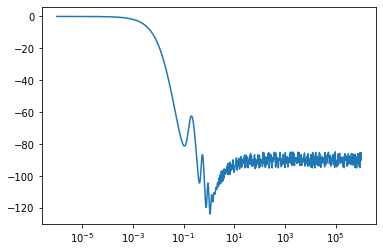

[1.36784436 1.24499467 0.28894387] [77.65506606 43.44277323  4.75287705]


(9.946920603922173, -2.6645352591003757e-15)

In [5]:
K, taui = [], []
for i in range(diag_freq.shape[1]):
    print(i)
    angs = numpy.unwrap(numpy.angle(diag_freq[:, i]))
    mags = numpy.abs(diag_freq[:, i])
    
    plt.loglog(ws, mags)
    plt.show()
    
    plt.semilogx(ws, angs/numpy.pi*180)
    plt.show()

    try:
        indx = numpy.where(abs(angs + numpy.pi) < 5e-2)[0][0]
    except:
        indx = numpy.argmin(angs)
    K.append(mags[indx]/2.2)
    taui.append(2*numpy.pi/1.2/ws[indx])
    
K = numpy.array(K)
taui = numpy.array(taui)
print(K, taui)

def Lcm_gen(G, Ks, tauis, F):
    N = Ks.shape[0]
    Ks = Ks/F
    tauis = tauis*F
    
    def K(s):
        return numpy.diag((Ks*tauis * s + Ks)/(tauis * s))
    
    L = lambda s: G(s) @ K(s)
    W = lambda s: numpy.linalg.det(numpy.eye(N) + L(s)) - 1
    Lcm = lambda s: 20 * numpy.log10(numpy.abs(W(s)/ (1 + W(s))))
    
    return Lcm

def obj(F):
    Lcm = Lcm_gen(G, K, taui, F)
    Lcms = numpy.array([Lcm(jw) for jw in jws])
    Lcm_max = max(Lcms)
    return Lcm_max - 2*K.shape[0]

F = scipy.optimize.brentq(obj, 1, 10)
F, obj(F)

In [6]:
K, taui

(array([1.36784436, 1.24499467, 0.28894387]),
 array([77.65506606, 43.44277323,  4.75287705]))

In [7]:
Ks = K/F
tauis = taui*F
Ks, tauis

(array([0.13751435, 0.12516383, 0.02904858]),
 array([772.42877658, 432.1218161 ,  47.2764907 ]))